<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
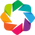

In [44]:
from io import StringIO
from pathlib import Path
import re
import math
import textwrap
from datetime import datetime
import earthaccess
import xarray as xr
import numpy as np
import pandas as pd
import panel as pn
from collections import defaultdict
from tqdm.notebook import tqdm
import cartopy.crs as ccrs

import functions as fc

import holoviews as hv
from bokeh.models import HoverTool, MercatorTickFormatter
from holoviews import opts
from holoviews.element.tiles import EsriImagery, OSM, CartoLight
hv.extension('bokeh')
pn.extension()

In [2]:
tspan = ("2024-09-22", "2024-09-28")
bbox = (-125., 32., -116., 38.)
areasize = (600, 900)
height, width = areasize
proj = ccrs.PlateCarree()

In [3]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=tspan,
    bounding_box=bbox,
    # cloud_cover=clouds,
)
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

In [4]:
def lonlat_to_mercator(lon, lat):
    k = 6378137.0
    x = lon * (math.pi/180.0) * k
    y = math.log(math.tan((90 + lat) * math.pi/360.0)) * k
    return x, y

def bbox_to_mercator(bbox):
    minlon, minlat, maxlon, maxlat = bbox
    minmerc_x, minmerc_y = lonlat_to_mercator(minlon, minlat)
    maxmerc_x, maxmerc_y = lonlat_to_mercator(maxlon, maxlat)
    return minmerc_x, minmerc_y, maxmerc_x, maxmerc_y
    
def get_OCI_PACE_truecolor(time, size=(400, 800), bbox=(-180, -90, 180, 90)):
    import numpy as np
    from owslib.wms import WebMapService
    import lxml.etree as xmltree
    import xml.etree.ElementTree as xmlet
    import requests
    from skimage import io
    """
      time: in format of YYYY-MM-DD
      size: (height, width)
      bbox: bounding box (minlon, minlat, maxlon, maxlat)
    """
    height, width = size
    minlon, minlat, maxlon, maxlat = bbox
    #  Construct Geographic projection URL.
    gibs_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?version=1.3.0&service=WMS&request=GetMap&format=image/png&STYLE=default'
    proj4326 = f'{gibs_url}&bbox={int(minlat)},{int(minlon)},{int(maxlat)},{int(maxlon)}&CRS=EPSG:4326&HEIGHT={height}&WIDTH={width}&TIME={time}&layers=OCI_PACE_True_Color'
    
    # Request image.
    img = io.imread(proj4326)
    minmerc_x, minmerc_y, maxmerc_x, maxmerc_y = bbox_to_mercator(bbox)
    x = np.linspace(minmerc_x, maxmerc_x, img.shape[1])
    y = np.linspace(minmerc_y, maxmerc_y, img.shape[0])
    img = img[::-1, :]

    return x, y, img

In [5]:
granules_data = []
for grmeta in tqdm(results, desc='Processing Granules'):
    gr_name = grmeta['umm']['GranuleUR']
    gr_time = grmeta['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']
    polygons = grmeta['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']['GPolygons']
    polygon_coord = [(lonlat_to_mercator(pt['Longitude'], pt['Latitude'])) for pt in polygons[0]['Boundary']['Points']]
    granules_data.append({'time': gr_time, 'granule': gr_name, 'geometry': polygon_coord})

Processing Granules:   0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
# ─── 1) DEFINE SB_PARSER ───────────────────────────────────────────────────────

def parse_sb(file_path):
    text = Path(file_path).read_text()
    header, body = text.split('/end_header', 1)

    # 1a) extract header entries
    metadata = {}
    for line in header.splitlines():
        if not line.startswith('/'): 
            continue
        if '=' not in line:    
            continue
        key, val = line[1:].split('=', 1)
        key, val = key.strip(), re.sub(r'\[.*?\]', '', val).strip()
        if key in {
            'station','data_file_name',
            'start_date','end_date',
            'start_time','end_time',
            'fields',
            'north_latitude','south_latitude',
            'west_longitude','east_longitude'
        }:
            metadata[key] = val

    # 1b) parse the /fields list & store it
    fields_list = [f.strip() for f in metadata['fields'].split(',')]
    metadata['fields_list'] = fields_list

    # 1c) read the body into a DataFrame
    df = pd.read_csv(
        StringIO(body.strip()),
        sep=',',
        names=fields_list,
        comment='/'
    )

    # 1d) detect single‐spectrum files & fill lat/lon if missing
    is_spectrum = ('lat' not in df.columns or 'lon' not in df.columns)
    metadata['single_spectrum'] = is_spectrum
    if is_spectrum:
        lat0 = float(metadata.get('north_latitude', metadata.get('south_latitude', 0)))
        lon0 = float(metadata.get('west_longitude',  metadata.get('east_longitude',  0)))
        df['lat'], df['lon'] = lat0, lon0

    # 1e) ensure date/time exist
    if 'date' not in df.columns:
        df['date'] = metadata['start_date']
    if 'time' not in df.columns:
        df['time'] = metadata['start_time']

    # 1f) build datetime column
    df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'])

    # 1g) parse header start/end datetimes
    def _pd(d, t):
        t_clean = re.sub(r'\[.*?\]', '', t)
        dfmt = '%Y-%m-%d' if '-' in d else '%Y%m%d'
        return datetime.strptime(f"{d} {t_clean}", f"{dfmt} %H:%M:%S")
    metadata['start_datetime'] = _pd(metadata['start_date'], metadata['start_time'])
    metadata['end_datetime']   = _pd(metadata['end_date'],   metadata['end_time'])

    # 1h) keep only the five columns you care about
    df = df[['date','time','lat','lon' '','datetime']]

    return metadata, df


In [58]:
dates = fc.get_dates(tspan[0], tspan[1], 24)
imgs = {}
for date in tqdm(dates, desc="Fetching true color from NASA WorldView"):
    daystr = date.strftime('%Y-%m-%d')
    x, y, img = get_OCI_PACE_truecolor(daystr, size=areasize, bbox=bbox)
    # img[:, :, 3] = img[:, :, 3] * 0.5
    imgs[daystr] = hv.RGB((x, y, img))

Fetching true color from NASA WorldView:   0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
# ─── 2.a) COLLECT & PREPARE ALL FILES ──────────────────────────────────────────

root = Path("/home/jovyan/shared-public/pace-hackweek/SeePACE/Hackweek_PACE-PAX_Rrs")
metadata_list = []
search_types = ['Rrs', 'AOP'] #  Add additional search parameters if desired ***********************

for sb in root.rglob('*.sb'):
    meta, df = parse_sb(sb)

    # collapse spectral files to exactly one row
    if meta['single_spectrum']:
        df = df.head(1)

    meta['data'] = df
    # detect which of your search_types appear in the original fields
    meta['Data_Type'] = [
        t for t in search_types
        if any(t in f for f in meta['fields_list'])
    ]
    metadata_list.append(meta)

summary_df = pd.DataFrame([{
    'Station':        m['station'],
    'Data_File_Name': m['data_file_name'],
    'Start_Datetime': m['start_datetime'],
    'End_Datetime':   m['end_datetime'],
    'Data_Type':      m['Data_Type']
} for m in metadata_list])

display(summary_df)

,Station,Data_File_Name,Start_Datetime,End_Datetime,Data_Type
0,30,PACE-PAX_Shearwater_2024_GER_St_30.sb,2024-09-22 19:25:46,2024-09-22 19:25:46,[Rrs]
1,31,PACE-PAX_Shearwater_2024_GER_St_31.sb,2024-09-22 20:34:41,2024-09-22 20:34:41,[Rrs]
2,32,PACE-PAX_Shearwater_2024_GER_St_32.sb,2024-09-23 18:05:43,2024-09-23 18:05:43,[Rrs]
3,33,PACE-PAX_Shearwater_2024_GER_St_33.sb,2024-09-23 20:08:33,2024-09-23 20:08:33,[Rrs]
4,34,PACE-PAX_Shearwater_2024_GER_St_34.sb,2024-09-25 19:36:20,2024-09-25 19:36:20,[Rrs]
...,...,...,...,...,...
273,NA,PVST_SBCR_04_20240920_194506_C-OPS_Rrs_Lu0_Es_...,2024-09-20 19:45:01,2024-09-20 19:45:01,[Rrs]
274,NA,PVST_SBCR_04_20240920_195005_C-OPS_Rrs_Lu0_Es_...,2024-09-20 19:50:02,2024-09-20 19:50:02,[Rrs]
275,NA,PVST_SBCR_04_20240920_202300_C-OPS_Rrs_Lu0_Es_...,2024-09-20 20:22:53,2024-09-20 20:22:53,[Rrs]
276,NA,PVST_SBCR_04_20240920_202844_C-OPS_Rrs_Lu0_Es_...,2024-09-20 20:28:43,2024-09-20 20:28:43,[Rrs]


In [13]:
# ─── 4) BUILD & CONCATENATE XR DATASETS ─────────────────────────────────────

ds_list    = []
file_names = []

for m in metadata_list:
    df = m['data'].reset_index(drop=True).reset_index().rename(columns={'index':'record'})
    ds = xr.Dataset(
        {
            'lat':      ('record', df['lat']),
            'lon':      ('record', df['lon']),
            'datetime': ('record', df['datetime'])
        },
        coords={'record': df['record']}
    )
    # promote to a 2-D Dataset along new 'file' dim
    ds = ds.expand_dims(file=[m['data_file_name']])
    ds_list.append(ds)
    file_names.append(m['data_file_name'])

ds_combined = xr.concat(
    ds_list,
    dim='file',
    coords='minimal',
    compat='override'
)

print(ds_combined)

# --- assemble full DataFrame of points ---
all_pts = []
for m in metadata_list:
    df = m['data'].copy()
    df['File']          = m['data_file_name']
    df['datetime']      = m['start_datetime']
    df['Data_Type_str'] = ', '.join(m['Data_Type'])
    df['merc_x'], df['merc_y'] = zip(*[
        lonlat_to_mercator(lon, lat) for lon, lat in zip(df['lon'], df['lat'])
    ])
    all_pts.append(df)
full_df = pd.concat(all_pts, ignore_index=True)

<xarray.Dataset> Size: 76kB
Dimensions:   (file: 278, record: 11)
Coordinates:
  * record    (record) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * file      (file) object 2kB 'PACE-PAX_Shearwater_2024_GER_St_30.sb' ... '...
Data variables:
    lat       (file, record) float64 24kB 33.68 nan nan nan ... nan nan nan nan
    lon       (file, record) float64 24kB -119.6 nan nan nan ... nan nan nan nan
    datetime  (file, record) datetime64[ns] 24kB 2024-09-22T19:25:46 NaT ... NaT


In [60]:
granules_by_date = defaultdict(list)
for g in granules_data:
    date = g['time'][:10]  # 'YYYY-MM-DD'
    granules_by_date[date].append(g)

# Sort the available days
available_days = sorted(set(imgs.keys()) | set(granules_by_date.keys()))

minmerc_x, minmerc_y, maxmerc_x, maxmerc_y = bbox_to_mercator(bbox)
x_range = (minmerc_x, maxmerc_x)
y_range = (minmerc_y, maxmerc_y)

# Wrap-and-merge filenames for hover
def wrap_files(vals):
    if len(vals)>1:
        names = sorted(set(vals))
        joined = ", ".join(names)
        text = textwrap.fill(joined, width=30).replace("\n", '<br>')
    else:
        text = textwrap.fill(str(vals[:]), width=30).replace("\n", '<br>')
    return text

# Function to generate a polygon from selected time
def make_granule_polygon(granules):
    poly_data = []
    for g in granules:
        poly_data.append({
            ('x', 'y'): g['geometry'],
            'granule': wrap_files([g['granule']]),
            'time': g['time']
        })
    return hv.Polygons(poly_data, vdims=['granule', 'time']).opts(
        fill_alpha=0.3,
        fill_color='pink',
        line_color='red',
        tools=[granule_hover]
    )

def make_insitu_points(df):
    grouped = df.groupby(['merc_x','merc_y'], as_index=False).agg({
        'datetime':       'max',
        'File':           wrap_files,
        'Data_Type_str':  lambda v: '<br>'.join(sorted(set(v)))
    })
    return hv.Points(
        grouped,
        kdims=['merc_x','merc_y'],
        vdims=['datetime','File','Data_Type_str']
    ).opts(
        size=8, color='blue', tools=[hover, 'wheel_zoom', 'pan'], active_tools=['wheel_zoom']
    )

def make_transects_lines(df):
    # Build transect lines per file
    lines = []
    for fname, sub in df.groupby('File'):
        if len(sub) > 1:
            # sort by datetime
            sub_sorted = sub.sort_values('datetime')
            coords = list(zip(sub_sorted['merc_x'], sub_sorted['merc_y']))
            line = hv.Path([coords], kdims=['x','y']).opts(color='red', line_width=2)
            lines.append(line)
    # Combine all lines
    if lines:
        return hv.Overlay(lines)
        # {f.name if hasattr(f, 'name') else i: f for i, f in enumerate(lines)}
    else:
        # Return an empty element if no line exists
        return hv.Path([])

granule_hover = HoverTool(
    tooltips="""
    <div style='max-width:300px;'>
      <strong>Granule:</strong> @granule<br>
      <strong>Time:</strong> @time
    </div>
    """,
    point_policy='follow_mouse'
)

hover = HoverTool(
    tooltips="""
    <div style='max-width:200px;'>
      <strong>Time:</strong> @datetime{%F}<br>
      <strong>File:</strong> @File{safe}<br>
      <strong>Type:</strong> @Data_Type_str
    </div>
    """,
    formatters={'@datetime':'datetime'},
    point_policy='snap_to_data'
)

def make_plot(selected_day=None, show_alldays=False, show_worldview=False, show_granules=False, show_esri=False, opacity=0.5):
    truecolor = imgs.get(selected_day)
    if truecolor is None:
        return hv.Text(0, 0, f"No image for {selected_day}").opts(width=600, height=500)

    if show_alldays:
        
        granules = sum(granules_by_date.values(), [])
        df = full_df.copy()
    else:
        granules = granules_by_date.get(selected_day, [])
        df = full_df[full_df['datetime'].dt.date == pd.to_datetime(selected_day).date()]
        
    polygons = [make_granule_polygon(granules)]
    points = [make_insitu_points(df)]
    transects = [make_transects_lines(df)]

    carto = CartoLight().opts(
        width=width, height=height,
        xaxis='bottom', yaxis='left',
        xformatter=MercatorTickFormatter(),
        yformatter=MercatorTickFormatter(),
        xlim=x_range, ylim=y_range,
        xlabel='Longitude',
        ylabel='Latitude',
    )
    # true-color world imagery
    imagery = EsriImagery().opts(
        width=width, height=height,
        xaxis='bottom', yaxis='left',
        xformatter=MercatorTickFormatter(),
        yformatter=MercatorTickFormatter(),
        xlim=x_range,
        ylim=y_range,
        xlabel='Longitude',
        ylabel='Latitude',
    )
    
    if not polygons:
        return hv.Text(0, 0, "No granules available").opts(width=600, height=500)
        
    n_points = len(df)
    elements = points + transects
    
    # Choose base
    overlay = imagery if show_esri else carto

    if show_worldview:
        overlay = overlay * truecolor.opts(alpha=opacity)
    if show_granules:
        overlay = overlay * hv.Overlay(polygons)
    overlay = overlay * hv.Overlay(elements)

    # return overlay
    return overlay.opts(
        ylim=y_range,
        xlim=x_range,
        width=x.size,
        height=y.size,
        xlabel='Longitude',
        ylabel='Latitude',
        framewise=False,
        title=f"Granules on {selected_day} / {n_points} in-situ points"
    )

alldays_toggle = pn.widgets.Checkbox(
    name='Show All Days',
    value=False
)
granules_toggle = pn.widgets.Checkbox(
    name='Show Granules',
    value=False
)
truecolor_toggle = pn.widgets.Checkbox(
    name='Show WorldView',
    value=False
)
toggle_esri = pn.widgets.Checkbox(name='Use Esri Imagery', value=False)

# Sliders
day_slider = pn.widgets.DiscreteSlider(name="Date", options=available_days)
alpha_slider = pn.widgets.FloatSlider(name='Overlay Opacity', start=0.0, end=1.0, step=0.05, value=1.0)

# Bind to panel
dynamic_map = pn.bind(
    make_plot,
    selected_day=day_slider, 
    show_alldays=alldays_toggle,
    show_worldview=truecolor_toggle,
    show_granules=granules_toggle,
    show_esri=toggle_esri,
    opacity=alpha_slider,
)

# Layout
app = pn.Column(
    "# Daily Granules and In-Situ Viewer",
    pn.Row(day_slider, alpha_slider),
    pn.Row(alldays_toggle, truecolor_toggle, granules_toggle, toggle_esri),
    dynamic_map
)

app.servable()

Column
    [0] Markdown(str)
    [1] Row
        [0] DiscreteSlider(name='Date', options=['2024-09-22', ...], value='2024-09-22')
        [1] FloatSlider(name='Overlay Opacity', step=0.05, value=1.0)
    [2] Row
        [0] Checkbox(name='Show All Days')
        [1] Checkbox(name='Show WorldView')
        [2] Checkbox(name='Show Granules')
        [3] Checkbox(name='Use Esri Imagery')
    [3] ParamFunction(function, _pane=HoloViews, defer_load=False)